In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt
import IPython

In [3]:
%matplotlib inline

In [4]:
import os

modelname="5_5_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0, split: str = "\n"):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte
        self.split = split

    def tokenize_str(self, sentence: str, encoding = "utf8") -> torch.Tensor:
        base = [int(i) for i in bytes(sentence, encoding)]
        if len(base) < self.n_pad:
            base.extend([self.pad_byte] * (self.n_pad - len(base)))
        assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding = "utf8") -> torch.Tensor:
        # tokenize the input text
        sentences = []
        for sentence in texts:
            sentences.append(self.tokenize_str(sentence).unsqueeze(0))

        return torch.cat(sentences, dim = 0).to(self.device)
    
    @staticmethod
    def prepare_texts(document: str) -> typing.List[str]:
        return filter(lambda x: len(x)!=0, document.split(self.split))
    
    def sequences_to_texts(self, texts: torch.Tensor, encoding = "utf8") -> typing.List[str]:
        out = []
        for seq in texts:
            chars = []
            i=0
            while i<len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i+=1
            out.append(bytes(chars).decode(encoding, "replace"))
        return out

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], n_pad):
        self.raw_data = data
        self.tokenizer = Tokenizer(n_pad, device, split = "\0")
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return self.tokenizer.tokenize_str(self.raw_data[index])

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode("utf8","replace")

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 640
batch_size = 32
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
print(f"Head size: {head_size}")
n_layers = 14

Head size: 10


In [15]:
path_to_data = "data/reddit_scrape_v8.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

187129


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model), "trainable params")

29080576 trainable params


In [18]:
input=next(testloader_iter)
input=input.to(device)
print(input.shape)
res = model(input)
print(res.shape)

torch.Size([1, 512])
torch.Size([1, 512, 256])


In [19]:
lr = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [20]:
n_epochs = 40

In [21]:
!nvidia-smi

Fri May  5 14:28:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   56C    P0    69W / 150W |   1506MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
print(device)

cuda


In [23]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 5848/5848 [1:12:20<00:00,  1.35it/s]


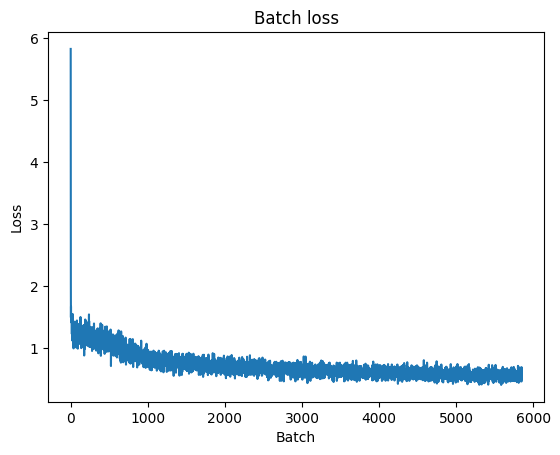

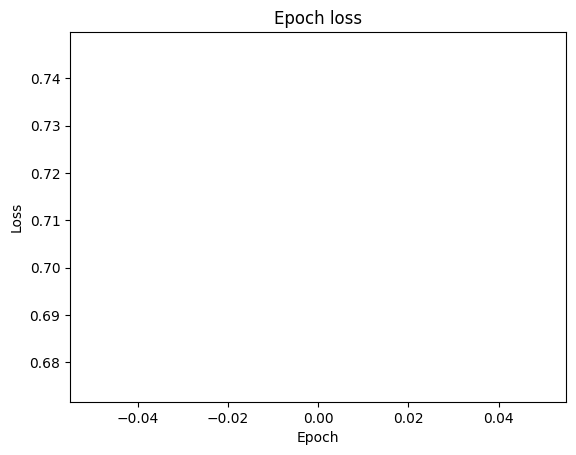

Prompt 0: Why does Earth orbit the Sun?
Model output (markdown): 

Why does Earth orbit the Sun?
I would like to see in the sun of the sun of the sun of the sun of the sun the sun of the sun of the sun the sun the sun of the sun the sun the san the sun the san the sun the san the san the san that it was a sun in the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun of the out or the outh.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, what do you use this is a relationship?
I would like to use this is a relationship with a relationship of the relationship of the relationship which were all the relationships of the relationships which were all the relationships of the relationships of the relationships of the relationships of the relationships of the relationships of the relationships of the relationships of the relationships of the post of the post of the post of the post of the post in the relationships of the post of the relearned thanks they were ansoulf.


Prompt 2: How to use ChatGPT?
Model output (markdown): 

How to use ChatGPT?
I want to use a school and change in the school and the school in the school in the school in the school. I would say the same thing in the school in the same in the same and the same that is a school and the same and the same and the same and the same that is a school and the same and the same and the same and the same that is a school and the school and the same and the same that it was a lot of the school and the school and the school of the school.


Prompt 3: My code does not work. What should I do?
Model output (markdown): 

My code does not work. What should I do?
I would recommend the same and the same and the same and the same thing that way the same and was a many that way to make a money of the money and the money and the money and the money and was a money and was a money and was a money and was a money was a money was a money and was a money was a money and was a many process and the money and was a money and the money and was a money and was a money about the money.


Prompt 4: Why is this code not working: `1+"A"`?
Model output (markdown): 

Why is this code not working: `1+"A"`?
I think it was a lot of code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I would like to be a lot of the problems with the problems in the problems with the problems in the problems will be a problem with a problem with a problem. I would be a problem with a problem with a problem with a problem with a problem with a problem with a problem. I would be a problem with a problem with a problem with a problem. I would be a problem with a problem with a problem.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I would like to be a lot of the most projects of the most projects of the most of the most projects that was a money of the most of the most productive in the most of the most of the most productive in the most of the most of the most of the most of the most productive in the most of the productive and the most of the productive of the productive is a most productive and the productive of the productive is a most productive and the productive is a productive and the productive of there.


Prompt 7: What is the purpose of the main() function in C?
Model output (markdown): 

What is the purpose of the main() function in C?
I would like to make a lot of the moon of the moon in the moon the moon of the moon in the moon and the moon of the moon is that is a monon of the moon of the moon and the moon is a mononous of the moon of the moon and the moon are the moon of the moon and the moon that is a mononous are all the moon are all the moon of the moon and the moon are the moon of the moon and the moon are the moon of the moon of the moon and the moon the moon of the moon of the moone.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I would like to be a problem with a problem with a problem with a problem with a problem with a problem with a problem with a problem with a problem with a problem with a problem. I would be a problem with a problem with a problem with a problem with a problem with a problem. I would be a problem with a problem with a problem with a problem with a problem. I would be a problem with a problem with a problem.


Epoch 2


100%|██████████| 5848/5848 [1:12:20<00:00,  1.35it/s]


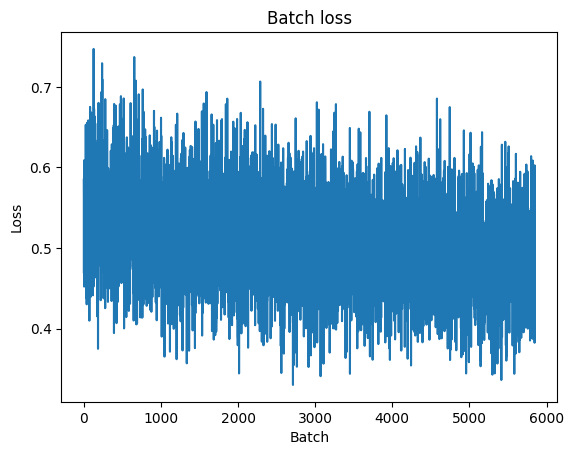

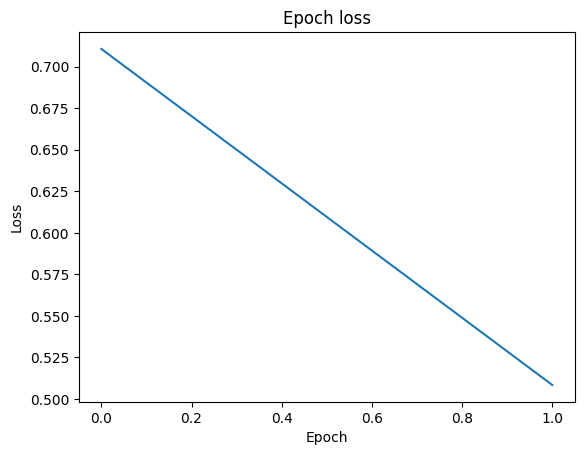

Prompt 0: Why does Earth orbit the Sun?
Model output (markdown): 

Why does Earth orbit the Sun?
I would say the sun is a good sun in the sun that it is a good sun in the sun and the sun is the sun that it is a good sun it is a good sun it is a good sun it is a good sun and it was a good sun and it was a good sun and it was a good sun and it was a good sun of the sun and then it was a good sun and it was a good sun a good sun a good sun of the sun of the sun and the sun of the sun of the sun of the sun of the sun of the sun of the sun of the sun of the sun ones of the sun of the sun of the sun it is wan a goood h averay aullab in so sunch an sun an an a a shearrouab.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, and what is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is the same thing that is a small thing that is a small thing that is a small thing that is a small thing that is a small thing is a small thing is a small thing.
I would say that is a small thing that is a small thing that is a small thing that is a small then is a small thing that is not a marrghanger.


Prompt 2: How to use ChatGPT?
Model output (markdown): 

How to use ChatGPT?
I would like to use a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a chatgpt that is a change and its a change that is a change and its a change that is a change and its a change that is a change and its a change that is a change and its a change and its a change and its a change and its a change and its a change and its a change and its a change and its a change and its a change and its a change and a change and a change and a a cchange ange and a a cchanger.


Prompt 3: My code does not work. What should I do?
Model output (markdown): 

My code does not work. What should I do?
I would say the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code. I would say the code in the code in the code in the code in the code in the code in the code in the code in the code. I would recommend the code in the code in the code in the code in the code in the code in the code in the code.


Prompt 4: Why is this code not working: `1+"A"`?
Model output (markdown): 

Why is this code not working: `1+"A"`?
I would say the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code in the code. I would recomend the code in the code in the code in the code in the code in the code in the code in the code in the code.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I would say that it is a manager for me that it is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I would say that is a manager for my code in Java and a manager school school school and the problem is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager that is a manager and is a manager.


Prompt 7: What is the purpose of the main() function in C?
Model output (markdown): 

What is the purpose of the main() function in C?
I would like to see a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes and classes a main classes.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I would say the same thing that is a great sample that is a great sample that is a great sample that is a great sample that is a great sample that is a great sample that is a great sample that is a great sample that is a great school that is a great school and it is a great school and its a great school and its a great school and its a great school and its a great school and its a great school and its a great school as a great school as a great school as a great school as a great school as a great schoool choool cancert.


Epoch 3


 43%|████▎     | 2518/5848 [31:08<41:09,  1.35it/s] 

In [ ]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
        
    #scheduler.step()    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            if not output.strip().endswith("<CUTOFF>"):
                print(f"Model output (markdown): ", end="")
                IPython.display.display(IPython.display.Markdown(output))
            else:
                print(f"Model output (raw): {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()